### Rose Tovar
### Linear Regression

In [75]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Helper Functions

In [2]:
# Helps with getting Genre name from json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [3]:
# Helps with getting production company
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

In [4]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*num_cols,*cat_features,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, y_train, X_test_df, y_test

In [5]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    

In [6]:
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [7]:
def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers

## Import Data

In [8]:
df = pd.read_csv('Data/tmdb_results_combined.csv.gz',lineterminator='\n')
df.head()

,Unnamed: 0.1,Unnamed: 0,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,0,tt0119970,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",NaN,165200.0,...,0.0,82.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future looks bleak,My Apocalypse,0.0,4.800,2.0,NaN
1,1,1,tt0166069,0.0,/rSbIlptJcd2TgoSB8YVgiJJKaSq.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",http://tsukamotoshinya.net/contents/?p=103,69469.0,...,0.0,47.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,The Adventure of Denchu-Kozo,0.0,6.100,25.0,NaN
2,2,2,tt0177636,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,8890.0,...,0.0,107.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Clara,0.0,4.700,6.0,NaN
3,3,3,tt0200465,0.0,/ynnarxTMs8jWKV9GK0SpUhGNCgH.jpg,NaN,20000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",http://thebankjobmovie.com/,8848.0,...,64828421.0,112.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The true story of a heist gone wrong... in all...,The Bank Job,0.0,6.820,1834.0,R
4,4,4,tt0211946,0.0,/8ZoW4hwuTWxKWDezkoUGBVvyxj5.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.berlin-calling.de/,30508.0,...,0.0,105.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Berlin Calling,0.0,6.846,286.0,NaN


In [9]:
# remove ids that are 0
df = df.loc[ df['imdb_id']!='0']
df

,Unnamed: 0.1,Unnamed: 0,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,0,tt0119970,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",NaN,165200.0,...,0.0,82.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future looks bleak,My Apocalypse,0.0,4.800,2.0,NaN
1,1,1,tt0166069,0.0,/rSbIlptJcd2TgoSB8YVgiJJKaSq.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",http://tsukamotoshinya.net/contents/?p=103,69469.0,...,0.0,47.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,The Adventure of Denchu-Kozo,0.0,6.100,25.0,NaN
2,2,2,tt0177636,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,8890.0,...,0.0,107.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Clara,0.0,4.700,6.0,NaN
3,3,3,tt0200465,0.0,/ynnarxTMs8jWKV9GK0SpUhGNCgH.jpg,NaN,20000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",http://thebankjobmovie.com/,8848.0,...,64828421.0,112.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The true story of a heist gone wrong... in all...,The Bank Job,0.0,6.820,1834.0,R
4,4,4,tt0211946,0.0,/8ZoW4hwuTWxKWDezkoUGBVvyxj5.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.berlin-calling.de/,30508.0,...,0.0,105.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Berlin Calling,0.0,6.846,286.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63179,63179,63179,tt8936254,0.0,NaN,"{'id': 728953, 'name': 'Fallen', 'poster_path'...",7000000.0,"[{'id': 14, 'name': 'Fantasy'}]",NaN,601644.0,...,0.0,83.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Fallen II: The Journey,0.0,7.700,14.0,NaN
63180,63180,63180,tt9271828,0.0,NaN,NaN,0.0,"[{'id': 99, 'name': 'Documentary'}]",NaN,561544.0,...,0.0,59.0,[],Released,NaN,Fred Baker - filmmaker,0.0,0.000,0.0,NaN
63181,63181,63181,tt9609716,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,360609.0,...,0.0,90.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,House of the Invisibles,0.0,0.000,0.0,NaN
63182,63182,63182,tt9643108,0.0,/zBXF10KsBVTCLivZIftV8tklsi6.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,592305.0,...,0.0,77.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,The Route 20 National Road,0.0,5.000,3.0,NaN


In [10]:
df = df.reset_index(drop=True)
df

,Unnamed: 0.1,Unnamed: 0,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,0,tt0119970,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",NaN,165200.0,...,0.0,82.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future looks bleak,My Apocalypse,0.0,4.800,2.0,NaN
1,1,1,tt0166069,0.0,/rSbIlptJcd2TgoSB8YVgiJJKaSq.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",http://tsukamotoshinya.net/contents/?p=103,69469.0,...,0.0,47.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,The Adventure of Denchu-Kozo,0.0,6.100,25.0,NaN
2,2,2,tt0177636,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,8890.0,...,0.0,107.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Clara,0.0,4.700,6.0,NaN
3,3,3,tt0200465,0.0,/ynnarxTMs8jWKV9GK0SpUhGNCgH.jpg,NaN,20000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",http://thebankjobmovie.com/,8848.0,...,64828421.0,112.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The true story of a heist gone wrong... in all...,The Bank Job,0.0,6.820,1834.0,R
4,4,4,tt0211946,0.0,/8ZoW4hwuTWxKWDezkoUGBVvyxj5.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.berlin-calling.de/,30508.0,...,0.0,105.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Berlin Calling,0.0,6.846,286.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63179,63179,63179,tt8936254,0.0,NaN,"{'id': 728953, 'name': 'Fallen', 'poster_path'...",7000000.0,"[{'id': 14, 'name': 'Fantasy'}]",NaN,601644.0,...,0.0,83.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Fallen II: The Journey,0.0,7.700,14.0,NaN
63180,63180,63180,tt9271828,0.0,NaN,NaN,0.0,"[{'id': 99, 'name': 'Documentary'}]",NaN,561544.0,...,0.0,59.0,[],Released,NaN,Fred Baker - filmmaker,0.0,0.000,0.0,NaN
63181,63181,63181,tt9609716,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,360609.0,...,0.0,90.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,House of the Invisibles,0.0,0.000,0.0,NaN
63182,63182,63182,tt9643108,0.0,/zBXF10KsBVTCLivZIftV8tklsi6.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,592305.0,...,0.0,77.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,The Route 20 National Road,0.0,5.000,3.0,NaN


In [12]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language',"Unnamed: 0", "Unnamed: 0.1"]
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certifcation
0,tt0119970,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",2008-03-21,0.0,82.0,My Apocalypse,4.800,2.0,NaN
1,tt0166069,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",3.501,"[{'id': 6853, 'logo_path': None, 'name': 'Kaij...",1987-01-01,0.0,47.0,The Adventure of Denchu-Kozo,6.100,25.0,NaN
2,tt0177636,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2.077,"[{'id': 393, 'logo_path': '/48DbAqzDc1ivGZrwGG...",2008-11-07,0.0,107.0,Clara,4.700,6.0,NaN
3,tt0200465,0.0,NaN,20000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",21.103,"[{'id': 507, 'logo_path': '/z7H707qUWigbjHnJDM...",2008-02-28,64828421.0,112.0,The Bank Job,6.820,1834.0,R
4,tt0211946,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",8.983,"[{'id': 1251, 'logo_path': '/fc0O0mvjl8PbHgZXX...",2008-10-01,0.0,105.0,Berlin Calling,6.846,286.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63179,tt8936254,0.0,"{'id': 728953, 'name': 'Fallen', 'poster_path'...",7000000.0,"[{'id': 14, 'name': 'Fantasy'}]",2.532,[],2007-07-30,0.0,83.0,Fallen II: The Journey,7.700,14.0,NaN
63180,tt9271828,0.0,NaN,0.0,"[{'id': 99, 'name': 'Documentary'}]",0.600,"[{'id': 111226, 'logo_path': None, 'name': 'Fr...",2007-07-26,0.0,59.0,Fred Baker - filmmaker,0.000,0.0,NaN
63181,tt9609716,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",0.611,"[{'id': 88553, 'logo_path': None, 'name': 'Glo...",2007-01-25,0.0,90.0,House of the Invisibles,0.000,0.0,NaN
63182,tt9643108,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,[],2007-01-01,0.0,77.0,The Route 20 National Road,5.000,3.0,NaN


### Belongs to Collection

In [13]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3981

In [14]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    59203
True      3981
Name: belongs_to_collection, dtype: int64

### Genres

In [15]:
df['genre_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genre_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certifcation,genre_list
0,tt0119970,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",2008-03-21,0.0,82.0,My Apocalypse,4.8,2.0,NaN,Drama
0,tt0119970,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",2008-03-21,0.0,82.0,My Apocalypse,4.8,2.0,NaN,Science Fiction
0,tt0119970,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",2008-03-21,0.0,82.0,My Apocalypse,4.8,2.0,NaN,Comedy
1,tt0166069,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",3.501,"[{'id': 6853, 'logo_path': None, 'name': 'Kaij...",1987-01-01,0.0,47.0,The Adventure of Denchu-Kozo,6.1,25.0,NaN,Horror
1,tt0166069,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",3.501,"[{'id': 6853, 'logo_path': None, 'name': 'Kaij...",1987-01-01,0.0,47.0,The Adventure of Denchu-Kozo,6.1,25.0,NaN,Science Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63179,tt8936254,0.0,True,7000000.0,"[{'id': 14, 'name': 'Fantasy'}]",2.532,[],2007-07-30,0.0,83.0,Fallen II: The Journey,7.7,14.0,NaN,Fantasy
63180,tt9271828,0.0,False,0.0,"[{'id': 99, 'name': 'Documentary'}]",0.600,"[{'id': 111226, 'logo_path': None, 'name': 'Fr...",2007-07-26,0.0,59.0,Fred Baker - filmmaker,0.0,0.0,NaN,Documentary
63181,tt9609716,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}]",0.611,"[{'id': 88553, 'logo_path': None, 'name': 'Glo...",2007-01-25,0.0,90.0,House of the Invisibles,0.0,0.0,NaN,Horror
63182,tt9643108,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,[],2007-01-01,0.0,77.0,The Route 20 National Road,5.0,3.0,NaN,Drama


In [16]:
unqiue_genres = df_explode['genre_list'].dropna().unique()
unqiue_genres

array(['Drama', 'Science Fiction', 'Comedy', 'Horror', 'Music',
       'Thriller', 'Crime', 'Romance', 'Adventure', 'Action', 'Fantasy',
       'Animation', 'Family', 'History', 'War', 'Mystery', 'Western',
       'Documentary', 'TV Movie'], dtype=object)

In [17]:
for genre in unqiue_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre, regex=False)

In [18]:
df.drop(columns=['genres', 'genre_list'], inplace=True)
df.head()

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,...,Genre_Action,Genre_Fantasy,Genre_Animation,Genre_Family,Genre_History,Genre_War,Genre_Mystery,Genre_Western,Genre_Documentary,Genre_TV Movie
0,tt0119970,0.0,False,0.0,0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",2008-03-21,0.0,82.0,My Apocalypse,...,False,False,False,False,False,False,False,False,False,False
1,tt0166069,0.0,False,0.0,3.501,"[{'id': 6853, 'logo_path': None, 'name': 'Kaij...",1987-01-01,0.0,47.0,The Adventure of Denchu-Kozo,...,False,False,False,False,False,False,False,False,False,False
2,tt0177636,0.0,False,0.0,2.077,"[{'id': 393, 'logo_path': '/48DbAqzDc1ivGZrwGG...",2008-11-07,0.0,107.0,Clara,...,False,False,False,False,False,False,False,False,False,False
3,tt0200465,0.0,False,20000000.0,21.103,"[{'id': 507, 'logo_path': '/z7H707qUWigbjHnJDM...",2008-02-28,64828421.0,112.0,The Bank Job,...,False,False,False,False,False,False,False,False,False,False
4,tt0211946,0.0,False,0.0,8.983,"[{'id': 1251, 'logo_path': '/fc0O0mvjl8PbHgZXX...",2008-10-01,0.0,105.0,Berlin Calling,...,False,False,False,False,False,False,False,False,False,False


### Certification

In [19]:
## Checking Certification values
# df['certification'].value_counts(dropna=False)

# fix extra space certs
df['certifcation'] = df['certifcation'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certifcation'] = df['certifcation'].replace(repl_cert)
df['certifcation'].value_counts(dropna=False)

NaN      48200
R         6177
NR        3468
PG-13     3265
PG        1456
G          446
NC-17      172
Name: certifcation, dtype: int64

In [20]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
## drop original feature
df = df.drop(columns=['release_date'])
df.head()

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,...,Genre_Family,Genre_History,Genre_War,Genre_Mystery,Genre_Western,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0119970,0.0,False,0.0,0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",0.0,82.0,My Apocalypse,4.800,...,False,False,False,False,False,False,False,2008.0,3.0,21.0
1,tt0166069,0.0,False,0.0,3.501,"[{'id': 6853, 'logo_path': None, 'name': 'Kaij...",0.0,47.0,The Adventure of Denchu-Kozo,6.100,...,False,False,False,False,False,False,False,1987.0,1.0,1.0
2,tt0177636,0.0,False,0.0,2.077,"[{'id': 393, 'logo_path': '/48DbAqzDc1ivGZrwGG...",0.0,107.0,Clara,4.700,...,False,False,False,False,False,False,False,2008.0,11.0,7.0
3,tt0200465,0.0,False,20000000.0,21.103,"[{'id': 507, 'logo_path': '/z7H707qUWigbjHnJDM...",64828421.0,112.0,The Bank Job,6.820,...,False,False,False,False,False,False,False,2008.0,2.0,28.0
4,tt0211946,0.0,False,0.0,8.983,"[{'id': 1251, 'logo_path': '/fc0O0mvjl8PbHgZXX...",0.0,105.0,Berlin Calling,6.846,...,False,False,False,False,False,False,False,2008.0,10.0,1.0


### Production Company

In [21]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

MISSING                                   22150
Canal+                                      605
Warner Bros. Pictures                       385
Universal Pictures                          363
CNC                                         323
France 2 Cinéma                             273
Columbia Pictures                           268
Lionsgate                                   248
StudioCanal                                 243
CJ Entertainment                            238
Ciné+                                       223
ARTE France Cinéma                          217
Paramount                                   214
20th Century Fox                            213
Toho                                        210
France 3 Cinéma                             210
Film i Väst                                 191
RAI                                         190
ZDF                                         181
ARTE                                        176
New Line Cinema                         

In [22]:
## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['01 Distribution',
 '20th Century Fox',
 'ARD',
 'ARTE',
 'ARTE France Cinéma',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'CNC',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'DreamWorks Pictures',
 'Eurimages',
 'Film i Väst',
 'Film4 Productions',
 'Focus Features',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'France Télévisions',
 'Gaumont',
 'Globo Filmes',
 'Kadokawa',
 'Lionsgate',
 'Lotte Entertainment',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'MiC',
 'Miramax',
 'New Line Cinema',
 'Nordisk Film',
 'Paramount',
 'RAI',
 'RAI Cinema',
 'Relativity Media',
 'Shochiku',
 'Showbox',
 'Star Cinema – ABS-CBN Film Productions',
 'StudioCanal',
 'TF1 Films Production',
 'TVE',
 'Toei Company',
 'Toho',
 'Téléfilm Canada',
 'Universal Pictures',
 'Walt Disney Pictures',
 'Warner Bros. Pictures',
 'Wild Bunch',
 'ZDF',
 'Česká televize']

In [23]:
## manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

In [24]:
df.head()

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
0,tt0119970,0.0,False,0.0,0.652,"[{'id': 182384, 'logo_path': None, 'name': 'Va...",0.0,82.0,My Apocalypse,4.800,...,False,False,False,False,False,False,False,False,False,False
1,tt0166069,0.0,False,0.0,3.501,"[{'id': 6853, 'logo_path': None, 'name': 'Kaij...",0.0,47.0,The Adventure of Denchu-Kozo,6.100,...,False,False,False,False,False,False,False,False,False,False
2,tt0177636,0.0,False,0.0,2.077,"[{'id': 393, 'logo_path': '/48DbAqzDc1ivGZrwGG...",0.0,107.0,Clara,4.700,...,False,False,False,False,False,False,False,False,False,False
3,tt0200465,0.0,False,20000000.0,21.103,"[{'id': 507, 'logo_path': '/z7H707qUWigbjHnJDM...",64828421.0,112.0,The Bank Job,6.820,...,False,False,False,False,False,False,False,False,False,False
4,tt0211946,0.0,False,0.0,8.983,"[{'id': 1251, 'logo_path': '/fc0O0mvjl8PbHgZXX...",0.0,105.0,Berlin Calling,6.846,...,False,False,False,False,False,False,False,False,False,False


In [25]:
## Dropping columns
drop_for_model = ['title','imdb_id','prod_company','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certifcation,Genre_Drama,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
0,0.0,False,0.0,0.652,0.0,82.0,4.800,2.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
1,0.0,False,0.0,3.501,0.0,47.0,6.100,25.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,False,0.0,2.077,0.0,107.0,4.700,6.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
3,0.0,False,20000000.0,21.103,64828421.0,112.0,6.820,1834.0,R,True,...,False,False,False,False,False,False,False,False,False,False
4,0.0,False,0.0,8.983,0.0,105.0,6.846,286.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63179,0.0,True,7000000.0,2.532,0.0,83.0,7.700,14.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63180,0.0,False,0.0,0.600,0.0,59.0,0.000,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63181,0.0,False,0.0,0.611,0.0,90.0,0.000,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63182,0.0,False,0.0,0.600,0.0,77.0,5.000,3.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False


### Intial Linear Regression Model

In [26]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

In [27]:
X_train_df.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certifcation_G,...,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize,const
54067,0.0,0.0,0.702,85.0,6.0,1.0,2011.000000,7.000000,16.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35933,0.0,0.0,0.783,82.0,4.2,4.0,2018.000000,6.000000,29.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11153,0.0,100000.0,0.600,100.0,0.0,0.0,2013.159616,6.540506,14.389858,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53716,0.0,200.0,0.919,65.0,0.0,0.0,2013.000000,7.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43275,0.0,0.0,0.600,0.0,0.0,0.0,2015.000000,9.000000,19.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1809.
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:28:23   Log-Likelihood:            -8.8304e+05
No. Observations:               47388   AIC:                         1.766e+06
Df Residuals:                   47303   BIC:                         1.767e+06
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
adult                                            1.204e+06   3.39e+06      0.355      0.723   -5.44e+06    7.85e+06
budget                                              1.6437      0.015    113.074      0.000       1.615       1.672
popularity                                       1.753e+05   8850.008     19.810      0.000    1.58e+05    1.93e+05
runtime                                         -3981.5465   4483.775     -0.888      0.375   -1.28e+04    4806.715
vote_average                                    -4.336e+05   5.75e+04     -7.540      0.000   -5.46e+05   -3.21e+05
vote_count                                       2.812e+04    197.022    142.719      0.000    2.77e+04    2.85e+04
year                                            -8095.6489    2.5e+04     -0.324      0.746    -5.7e+04    4.09e+04
month                                           -5.609e+04   3.94e+04     -1.423      0.155   -1.33e+05    2.12e+04
day                                             -3173.9546   1.52e+04     -0.209      0.835    -3.3e+04    2.67e+04
certifcation_G                                   3.055e+06   6.45e+06      0.473      0.636    -9.6e+06    1.57e+07
certifcation_MISSING                             5.886e+06   6.33e+06      0.931      0.352   -6.51e+06    1.83e+07
certifcation_NC-17                               2.551e+06   6.75e+06      0.378      0.706   -1.07e+07    1.58e+07
certifcation_NR                                  4.846e+06   6.35e+06      0.763      0.445    -7.6e+06    1.73e+07
certifcation_PG                                  5.758e+06   6.33e+06      0.909      0.363   -6.66e+06    1.82e+07
certifcation_PG-13                               -2.48e+06    6.3e+06     -0.393      0.694   -1.48e+07    9.88e+06
certifcation_R                                  -7.337e+06   6.27e+06     -1.170      0.242   -1.96e+07    4.95e+06
belongs_to_collection                            1.046e+07   6.15e+05     17.009      0.000    9.26e+06    1.17e+07
Genre_Drama                                      -8.15e+04   3.18e+05     -0.256      0.798   -7.05e+05    5.42e+05
Genre_Science Fiction                           -5.243e+06   6.39e+05     -8.208      0.000    -6.5e+06   -3.99e+06
Genre_Comedy                                     4.382e+05   3.41e+05      1.283      0.199   -2.31e+05    1.11e+06
Genre_Horror                                    -2.455e+05    4.3e+05     -0.571      0.568   -1.09e+06    5.97e+05
Genre_Music                                      1.538e+06   9.96e+05      1.545      0.122   -4.13e+05    3.49e+06
Genre_Thriller                                  -8.352e+05   4.06e+05     -2.060      0.039   -1.63e+06   -4.04e+04
Genre_Crime                                     -2.008e+06   5.51e+

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1809.
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:28:23   Log-Likelihood:            -8.8304e+05
No. Observations:               47388   AIC:                         1.766e+06
Df Residuals:                   47303   BIC:                         1.767e+06
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
adult                                            1.204e+06   3.39e+06      0.355      0.723   -5.44e+06    7.85e+06
budget                                              1.6437      0.015    113.074      0.000       1.615       1.672
popularity                                       1.753e+05   8850.008     19.810      0.000    1.58e+05    1.93e+05
runtime                                         -3981.5465   4483.775     -0.888      0.375   -1.28e+04    4806.715
vote_average                                    -4.336e+05   5.75e+04     -7.540      0.000   -5.46e+05   -3.21e+05
vote_count                                       2.812e+04    197.022    142.719      0.000    2.77e+04    2.85e+04
year                                            -8095.6489    2.5e+04     -0.324      0.746    -5.7e+04    4.09e+04
month                                           -5.609e+04   3.94e+04     -1.423      0.155   -1.33e+05    2.12e+04
day                                             -3173.9546   1.52e+04     -0.209      0.835    -3.3e+04    2.67e+04
certifcation_G                                   3.055e+06   6.45e+06      0.473      0.636    -9.6e+06    1.57e+07
certifcation_MISSING                             5.886e+06   6.33e+06      0.931      0.352   -6.51e+06    1.83e+07
certifcation_NC-17                               2.551e+06   6.75e+06      0.378      0.706   -1.07e+07    1.58e+07
certifcation_NR                                  4.846e+06   6.35e+06      0.763      0.445    -7.6e+06    1.73e+07
certifcation_PG                                  5.758e+06   6.33e+06      0.909      0.363   -6.66e+06    1.82e+07
certifcation_PG-13                               -2.48e+06    6.3e+06     -0.393      0.694   -1.48e+07    9.88e+06
certifcation_R                                  -7.337e+06   6.27e+06     -1.170      0.242   -1.96e+07    4.95e+06
belongs_to_collection                            1.046e+07   6.15e+05     17.009      0.000    9.26e+06    1.17e+07
Genre_Drama                                      -8.15e+04   3.18e+05     -0.256      0.798   -7.05e+05    5.42e+05
Genre_Science Fiction                           -5.243e+06   6.39e+05     -8.208      0.000    -6.5e+06   -3.99e+06
Genre_Comedy                                     4.382e+05   3.41e+05      1.283      0.199   -2.31e+05    1.11e+06
Genre_Horror                                    -2.455e+05    4.3e+05     -0.571      0.568   -1.09e+06    5.97e+05
Genre_Music                                      1.538e+06   9.96e+05      1.545      0.122   -4.13e+05    3.49e+06
Genre_Thriller                                  -8.352e+05   4.06e+05     -2.060      0.039   -1.63e+06   -4.04e+04
Genre_Crime                                     -2.008e+06   5.51e+

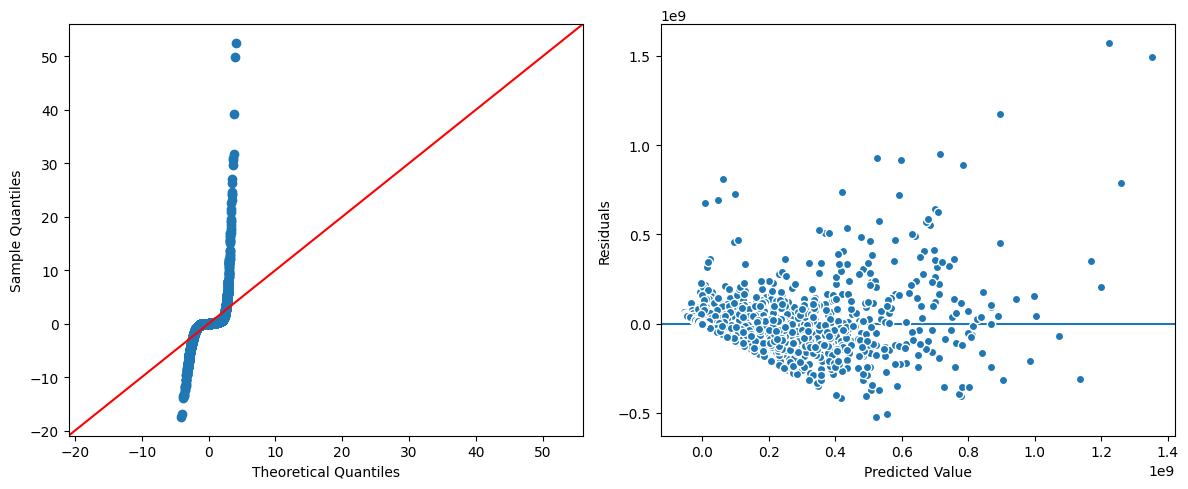

In [29]:
evaluate_ols(result, X_train_df, y_train)

In [30]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.763
Testing R^2: 0.741


## Improving with Additional Feature Engineering

In [31]:
df = pd.read_csv('Data/tmdb_results_combined.csv.gz', lineterminator='\n')
df.head()

,Unnamed: 0.1,Unnamed: 0,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certifcation
0,0,0,tt0119970,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",NaN,165200.0,...,0.0,82.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future looks bleak,My Apocalypse,0.0,4.800,2.0,NaN
1,1,1,tt0166069,0.0,/rSbIlptJcd2TgoSB8YVgiJJKaSq.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",http://tsukamotoshinya.net/contents/?p=103,69469.0,...,0.0,47.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,The Adventure of Denchu-Kozo,0.0,6.100,25.0,NaN
2,2,2,tt0177636,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,8890.0,...,0.0,107.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Clara,0.0,4.700,6.0,NaN
3,3,3,tt0200465,0.0,/ynnarxTMs8jWKV9GK0SpUhGNCgH.jpg,NaN,20000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",http://thebankjobmovie.com/,8848.0,...,64828421.0,112.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The true story of a heist gone wrong... in all...,The Bank Job,0.0,6.820,1834.0,R
4,4,4,tt0211946,0.0,/8ZoW4hwuTWxKWDezkoUGBVvyxj5.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.berlin-calling.de/,30508.0,...,0.0,105.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,NaN,Berlin Calling,0.0,6.846,286.0,NaN


### Initial Cleaning

In [32]:
## Columns to exclude - Keeping Status and companies
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', #'status','production_companies'
                 'production_countries','video','spoken_languages',
            'original_language', "Unnamed: 0", "Unnamed: 0.1"]
df = df.drop(columns=drop_cols)
df = df.loc[ df['imdb_id']!='0']
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()

## Function to get just the genre names as a list 
import json

## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    


## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])


#### Fixing Certification
## Checking Certification values
df['certifcation'].value_counts(dropna=False)
# fix extra space certs
df['certifcation'] = df['certifcation'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certifcation'] = df['certifcation'].replace(repl_cert)
df['certifcation'].value_counts(dropna=False)


#### Converting year to sep features
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])

df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

## Dropping columns
drop = ['title', 'imdb_id','prod_company','production_companies']
df = df.drop(columns=drop)
df.head()

,adult,belongs_to_collection,budget,popularity,revenue,runtime,status,vote_average,vote_count,certifcation,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
0,0.0,False,0.0,0.652,0.0,82.0,Released,4.800,2.0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,0.0,False,0.0,3.501,0.0,47.0,Released,6.100,25.0,NaN,...,False,False,False,False,False,False,False,False,False,False
2,0.0,False,0.0,2.077,0.0,107.0,Released,4.700,6.0,NaN,...,False,False,False,False,False,False,False,False,False,False
3,0.0,False,20000000.0,21.103,64828421.0,112.0,Released,6.820,1834.0,R,...,False,False,False,False,False,False,False,False,False,False
4,0.0,False,0.0,8.983,0.0,105.0,Released,6.846,286.0,NaN,...,False,False,False,False,False,False,False,False,False,False


In [33]:
df['status'].value_counts()

Released           63119
Post Production       45
In Production         13
Planned                6
Rumored                1
Name: status, dtype: int64

### Status must be released

In [34]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certifcation,Genre_Drama,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
0,0.0,False,0.0,0.652,0.0,82.0,4.800,2.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
1,0.0,False,0.0,3.501,0.0,47.0,6.100,25.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,False,0.0,2.077,0.0,107.0,4.700,6.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
3,0.0,False,20000000.0,21.103,64828421.0,112.0,6.820,1834.0,R,True,...,False,False,False,False,False,False,False,False,False,False
4,0.0,False,0.0,8.983,0.0,105.0,6.846,286.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63179,0.0,True,7000000.0,2.532,0.0,83.0,7.700,14.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63180,0.0,False,0.0,0.600,0.0,59.0,0.000,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63181,0.0,False,0.0,0.611,0.0,90.0,0.000,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63182,0.0,False,0.0,0.600,0.0,77.0,5.000,3.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False


### Budget and Revenue must be greater than 0

In [35]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certifcation,Genre_Drama,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
3,0.0,False,20000000.0,21.103,64828421.0,112.0,6.820,1834.0,R,True,...,False,False,False,False,False,False,False,False,False,False
8,0.0,False,40000000.0,7.971,694782.0,94.0,5.031,49.0,PG,False,...,False,False,False,False,False,False,False,False,False,False
11,0.0,False,70000000.0,16.030,72109200.0,101.0,5.571,1720.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
12,0.0,False,18000000.0,10.672,2783332.0,120.0,6.649,205.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
13,0.0,True,185000000.0,39.789,786636033.0,122.0,5.965,6881.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63021,0.0,True,10000.0,1.198,100000.0,104.0,6.300,9.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
63044,0.0,False,470000.0,2.084,3800000.0,141.0,7.000,15.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63066,0.0,False,1200000.0,0.600,910000.0,0.0,0.000,0.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63114,0.0,False,5900000.0,1.522,618400.0,76.0,3.500,2.0,PG,False,...,False,False,False,False,False,False,False,False,False,False


## Check for Linearity

In [40]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)
X_train_df.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certifcation_G,...,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize,const
61807,0.0,100000000.0,35.069,157.0,7.582,4519.0,2007.0,11.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
19621,0.0,5000.0,25.420,117.0,7.938,7515.0,2013.0,11.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
23035,0.0,100000.0,1.089,145.0,7.900,8.0,2013.0,9.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23513,0.0,100000000.0,34.707,125.0,5.701,1487.0,2016.0,8.0,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46976,0.0,22000000.0,22.898,92.0,6.496,1747.0,2014.0,9.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
plot_df = pd.concat([X_train_df, y_train], axis=1)

In [46]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre') | c.startswith("Prod")]
plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
len(plot_cols)

18

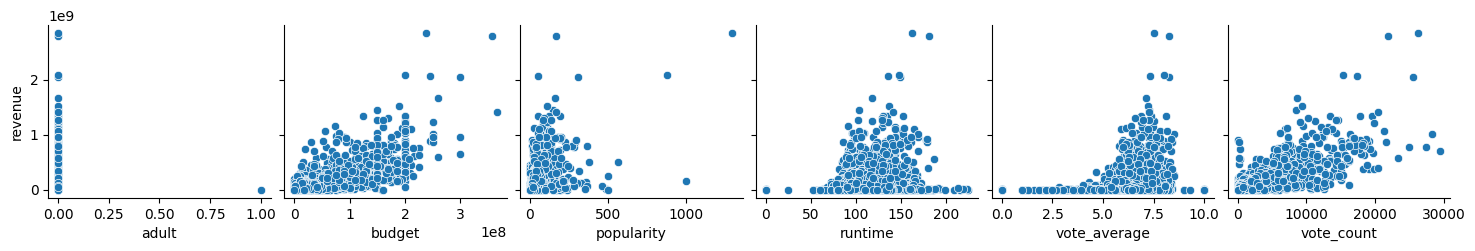

In [47]:
## Plot first 6 features
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6])

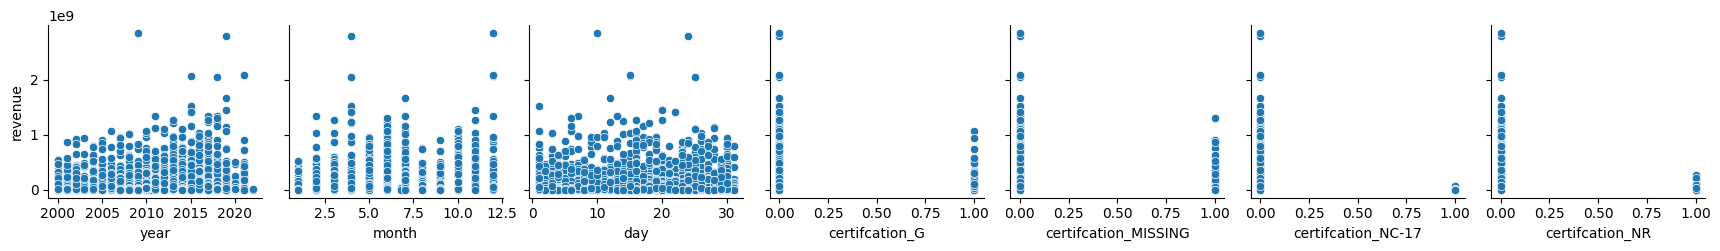

In [48]:
## Plot next 6 features
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[6:13])

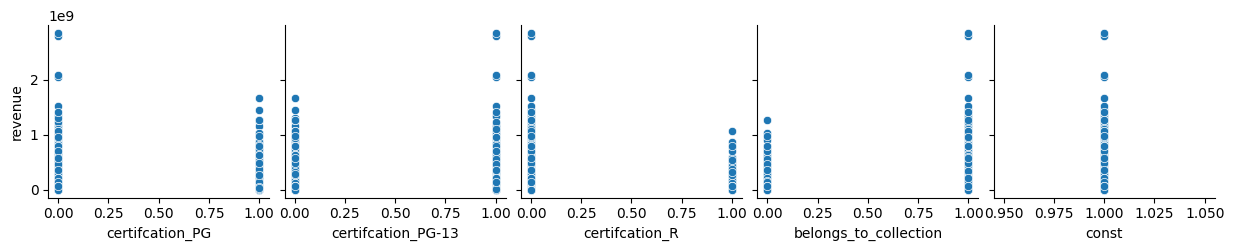

In [49]:
## plot remaining features

sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[13:])

 - From initial inspection both popularity and vote_average are not linear, along with the release years

In [55]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

In [56]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     147.8
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:39:28   Log-Likelihood:                -77183.
No. Observations:                3902   AIC:                         1.545e+05
Df Residuals:                    3819   BIC:                         1.551e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
adult                                             3.16e+06   9.55e+07      0.033      0.974   -1.84e+08     1.9e+08
budget                                              1.9159      0.060     32.200      0.000       1.799       2.033
popularity                                       4.417e+05   3.76e+04     11.737      0.000    3.68e+05    5.15e+05
runtime                                          2.364e+05   8.72e+04      2.712      0.007    6.55e+04    4.07e+05
vote_average                                    -4.393e+06   1.47e+06     -2.979      0.003   -7.28e+06    -1.5e+06
vote_count                                       2.621e+04    711.445     36.836      0.000    2.48e+04    2.76e+04
year                                             1.967e+04   2.88e+05      0.068      0.946   -5.46e+05    5.85e+05
month                                           -3.108e+05   4.54e+05     -0.685      0.494    -1.2e+06    5.79e+05
day                                               5.01e+04    1.8e+05      0.278      0.781   -3.04e+05    4.04e+05
certifcation_G                                  -1.186e+07   7.27e+07     -0.163      0.870   -1.54e+08    1.31e+08
certifcation_MISSING                             5.316e+06   7.32e+07      0.073      0.942   -1.38e+08    1.49e+08
certifcation_NC-17                              -9.827e+06   7.74e+07     -0.127      0.899   -1.62e+08    1.42e+08
certifcation_NR                                  1.521e+06   7.34e+07      0.021      0.983   -1.42e+08    1.45e+08
certifcation_PG                                  -2.45e+06   7.27e+07     -0.034      0.973   -1.45e+08     1.4e+08
certifcation_PG-13                               -1.09e+07   7.26e+07     -0.150      0.881   -1.53e+08    1.31e+08
certifcation_R                                  -2.723e+07   7.25e+07     -0.375      0.707   -1.69e+08    1.15e+08
belongs_to_collection                            4.536e+07    4.2e+06     10.796      0.000    3.71e+07    5.36e+07
Genre_Drama                                      1.179e+06   4.05e+06      0.291      0.771   -6.76e+06    9.12e+06
Genre_Science Fiction                           -3.022e+07    5.8e+06     -5.213      0.000   -4.16e+07   -1.89e+07
Genre_Comedy                                     1.398e+06   3.98e+06      0.351      0.726   -6.41e+06    9.21e+06
Genre_Horror                                    -2.422e+06   5.85e+06     -0.414      0.679   -1.39e+07    9.05e+06
Genre_Music                                      1.403e+07   9.08e+06      1.545      0.123   -3.78e+06    3.18e+07
Genre_Thriller                                  -3.453e+06   4.28e+06     -0.807      0.420   -1.18e+07    4.94e+06
Genre_Crime                                     -6.373e+06   4.92e+

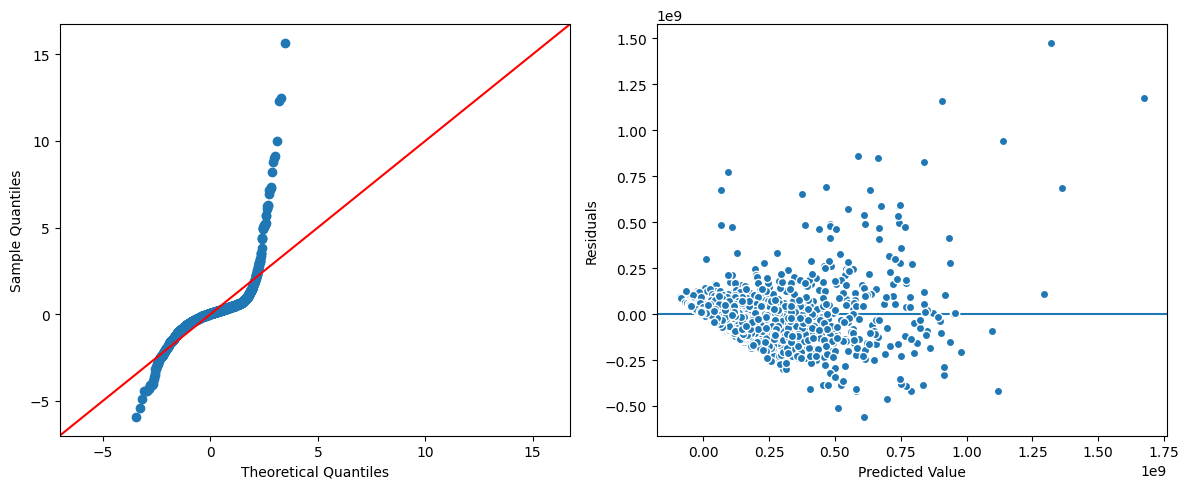

In [57]:
## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

## Removing Outliers

In [58]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']

outliers = {}
for col in outlier_cols:
    outliers_col = find_outliers(df[col])
    outliers[col] = outliers_col

- 67 outliers found in runtime using Z-Scores.
- 79 outliers found in popularity using Z-Scores.
- 131 outliers found in revenue using Z-Scores.


In [59]:
# Make new df_clean copy of df
df_clean = df.copy()

## loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean

/tmp/ipykernel_11066/1890287056.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certifcation,Genre_Drama,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
3,0.0,False,20000000.0,21.103,64828421.0,112.0,6.820,1834.0,R,True,...,False,False,False,False,False,False,False,False,False,False
8,0.0,False,40000000.0,7.971,694782.0,94.0,5.031,49.0,PG,False,...,False,False,False,False,False,False,False,False,False,False
11,0.0,False,70000000.0,16.030,72109200.0,101.0,5.571,1720.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
12,0.0,False,18000000.0,10.672,2783332.0,120.0,6.649,205.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
15,0.0,False,80000000.0,12.703,163733697.0,88.0,5.793,919.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62927,0.0,True,215000.0,70.380,194183034.0,85.0,5.992,4304.0,R,False,...,False,False,False,False,False,False,False,False,False,False
63021,0.0,True,10000.0,1.198,100000.0,104.0,6.300,9.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
63044,0.0,False,470000.0,2.084,3800000.0,141.0,7.000,15.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63114,0.0,False,5900000.0,1.522,618400.0,76.0,3.500,2.0,PG,False,...,False,False,False,False,False,False,False,False,False,False


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     147.5
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:40:34   Log-Likelihood:                -71325.
No. Observations:                3716   AIC:                         1.428e+05
Df Residuals:                    3632   BIC:                         1.433e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
adult                                           -2.685e+06   5.32e+07     -0.051      0.960   -1.07e+08    1.02e+08
budget                                              1.2970      0.038     34.265      0.000       1.223       1.371
popularity                                       3.874e+05   5.07e+04      7.649      0.000    2.88e+05    4.87e+05
runtime                                          1.795e+05   5.68e+04      3.157      0.002     6.8e+04    2.91e+05
vote_average                                     -1.04e+06   8.51e+05     -1.221      0.222   -2.71e+06    6.29e+05
vote_count                                       1.956e+04    513.795     38.079      0.000    1.86e+04    2.06e+04
year                                            -2.854e+05   1.67e+05     -1.709      0.087   -6.13e+05     4.2e+04
month                                           -6.329e+04   2.57e+05     -0.246      0.806   -5.67e+05    4.41e+05
day                                             -6.541e+04   1.03e+05     -0.637      0.524   -2.67e+05    1.36e+05
certifcation_G                                   8.084e+07   4.22e+07      1.918      0.055   -1.81e+06    1.63e+08
certifcation_MISSING                              6.98e+07   4.24e+07      1.648      0.099   -1.32e+07    1.53e+08
certifcation_NC-17                               6.727e+07   4.46e+07      1.510      0.131   -2.01e+07    1.55e+08
certifcation_NR                                  6.628e+07   4.24e+07      1.563      0.118   -1.68e+07    1.49e+08
certifcation_PG                                  8.118e+07    4.2e+07      1.931      0.054   -1.23e+06    1.64e+08
certifcation_PG-13                                6.36e+07    4.2e+07      1.514      0.130   -1.87e+07    1.46e+08
certifcation_R                                   5.335e+07    4.2e+07      1.271      0.204   -2.89e+07    1.36e+08
belongs_to_collection                            3.353e+07   2.42e+06     13.876      0.000    2.88e+07    3.83e+07
Genre_Drama                                     -1.239e+06   2.29e+06     -0.541      0.588   -5.73e+06    3.25e+06
Genre_Science Fiction                           -2.459e+07   3.35e+06     -7.339      0.000   -3.12e+07    -1.8e+07
Genre_Comedy                                     8.587e+06    2.3e+06      3.730      0.000    4.07e+06    1.31e+07
Genre_Horror                                      6.07e+05   3.34e+06      0.182      0.856   -5.93e+06    7.15e+06
Genre_Music                                      1.417e+07   5.48e+06      2.586      0.010    3.43e+06    2.49e+07
Genre_Thriller                                  -4.674e+05   2.44e+06     -0.192      0.848   -5.25e+06    4.32e+06
Genre_Crime                                     -4.339e+06    2.8e+

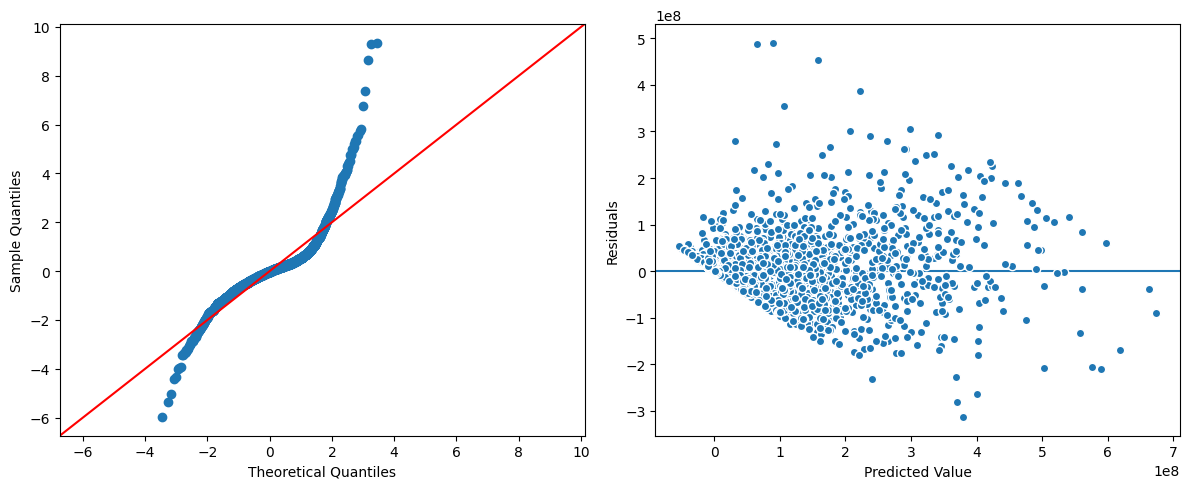

In [60]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean)
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

<AxesSubplot:xlabel='revenue'>

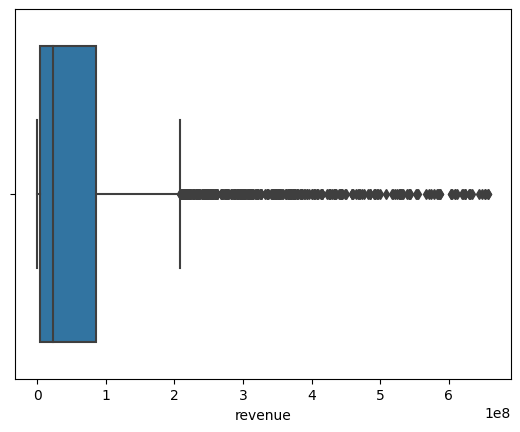

In [61]:
## visualzie outlier-removed target
sns.boxplot(x = y_train)

In [62]:

outliers_z = find_outliers(df['revenue'])
outliers_z

- 131 outliers found in revenue using Z-Scores.


3        False
8        False
11       False
12       False
13        True
         ...  
63021    False
63044    False
63066    False
63114    False
63117    False
Name: revenue, Length: 5203, dtype: bool

In [63]:
## Loop to remove outliers from same clumns using new function
outlier_cols = ['runtime','popularity','revenue']

## Empty dict for both types of outliers
outliers_z = {}
outliers_iqr = {}

## Use both functions to see the comparison for # of outliers
for col in outlier_cols:
    outliers_col_z = find_outliers(df[col])
    outliers_z[col] = outliers_col_z
    
    outliers_col_iqr = find_outliers_IQR(df[col])
    outliers_iqr[col] = outliers_col_iqr

- 67 outliers found in runtime using Z-Scores.
- 171 outliers found in runtime using IQR.
- 79 outliers found in popularity using Z-Scores.
- 531 outliers found in popularity using IQR.
- 131 outliers found in revenue using Z-Scores.
- 558 outliers found in revenue using IQR.


In [64]:
# remove_outliers 
df_clean_z = df.copy()
for col, idx_outliers in outliers_z.items():
    df_clean_z = df_clean_z[~idx_outliers]
df_clean_z

/tmp/ipykernel_11066/3429278998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_z = df_clean_z[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certifcation,Genre_Drama,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
3,0.0,False,20000000.0,21.103,64828421.0,112.0,6.820,1834.0,R,True,...,False,False,False,False,False,False,False,False,False,False
8,0.0,False,40000000.0,7.971,694782.0,94.0,5.031,49.0,PG,False,...,False,False,False,False,False,False,False,False,False,False
11,0.0,False,70000000.0,16.030,72109200.0,101.0,5.571,1720.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
12,0.0,False,18000000.0,10.672,2783332.0,120.0,6.649,205.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
15,0.0,False,80000000.0,12.703,163733697.0,88.0,5.793,919.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62927,0.0,True,215000.0,70.380,194183034.0,85.0,5.992,4304.0,R,False,...,False,False,False,False,False,False,False,False,False,False
63021,0.0,True,10000.0,1.198,100000.0,104.0,6.300,9.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
63044,0.0,False,470000.0,2.084,3800000.0,141.0,7.000,15.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63114,0.0,False,5900000.0,1.522,618400.0,76.0,3.500,2.0,PG,False,...,False,False,False,False,False,False,False,False,False,False


In [65]:

# remove_outliers  to create df_clean_iqr
df_clean_iqr = df.copy()
for col, idx_outliers in outliers_iqr.items():
    df_clean_iqr = df_clean_iqr[~idx_outliers]
df_clean_iqr

/tmp/ipykernel_11066/4214965391.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_iqr = df_clean_iqr[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certifcation,Genre_Drama,...,ProdComp_TVE,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize
3,0.0,False,20000000.0,21.103,64828421.0,112.0,6.820,1834.0,R,True,...,False,False,False,False,False,False,False,False,False,False
8,0.0,False,40000000.0,7.971,694782.0,94.0,5.031,49.0,PG,False,...,False,False,False,False,False,False,False,False,False,False
11,0.0,False,70000000.0,16.030,72109200.0,101.0,5.571,1720.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
12,0.0,False,18000000.0,10.672,2783332.0,120.0,6.649,205.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
15,0.0,False,80000000.0,12.703,163733697.0,88.0,5.793,919.0,PG-13,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62831,0.0,False,5000000.0,1.400,1413000.0,91.0,2.200,4.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63021,0.0,True,10000.0,1.198,100000.0,104.0,6.300,9.0,NaN,True,...,False,False,False,False,False,False,False,False,False,False
63044,0.0,False,470000.0,2.084,3800000.0,141.0,7.000,15.0,NaN,False,...,False,False,False,False,False,False,False,False,False,False
63114,0.0,False,5900000.0,1.522,618400.0,76.0,3.500,2.0,PG,False,...,False,False,False,False,False,False,False,False,False,False


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     74.34
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:42:27   Log-Likelihood:                -59430.
No. Observations:                3192   AIC:                         1.190e+05
Df Residuals:                    3109   BIC:                         1.195e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
adult                                           -5.662e+06      3e+07     -0.189      0.850   -6.44e+07    5.31e+07
budget                                              0.7884      0.031     25.380      0.000       0.727       0.849
popularity                                       4.527e+05   5.92e+04      7.641      0.000    3.37e+05    5.69e+05
runtime                                          1.072e+05   3.72e+04      2.885      0.004    3.43e+04     1.8e+05
vote_average                                     5.632e+05   5.02e+05      1.121      0.262   -4.22e+05    1.55e+06
vote_count                                       1.216e+04    446.822     27.216      0.000    1.13e+04     1.3e+04
year                                            -3.774e+05   1.04e+05     -3.623      0.000   -5.82e+05   -1.73e+05
month                                           -2.321e+05   1.57e+05     -1.476      0.140    -5.4e+05    7.62e+04
day                                             -5.948e+04   6.23e+04     -0.955      0.340   -1.82e+05    6.26e+04
certifcation_G                                    1.09e+08   2.63e+07      4.138      0.000    5.73e+07    1.61e+08
certifcation_MISSING                             9.072e+07   2.64e+07      3.434      0.001    3.89e+07    1.43e+08
certifcation_NC-17                               8.936e+07   2.74e+07      3.263      0.001    3.57e+07    1.43e+08
certifcation_NR                                  9.044e+07   2.64e+07      3.424      0.001    3.86e+07    1.42e+08
certifcation_PG                                  9.819e+07   2.62e+07      3.743      0.000    4.68e+07     1.5e+08
certifcation_PG-13                               9.534e+07   2.62e+07      3.643      0.000     4.4e+07    1.47e+08
certifcation_R                                   8.217e+07   2.62e+07      3.141      0.002    3.09e+07    1.33e+08
belongs_to_collection                            1.801e+07    1.6e+06     11.285      0.000    1.49e+07    2.11e+07
Genre_Drama                                     -5.362e+06   1.38e+06     -3.888      0.000   -8.07e+06   -2.66e+06
Genre_Science Fiction                           -1.788e+07   2.18e+06     -8.216      0.000   -2.21e+07   -1.36e+07
Genre_Comedy                                     4.602e+06   1.39e+06      3.313      0.001    1.88e+06    7.33e+06
Genre_Horror                                     1.098e+06   2.02e+06      0.544      0.586   -2.86e+06    5.06e+06
Genre_Music                                      6.136e+06   3.22e+06      1.908      0.056   -1.69e+05    1.24e+07
Genre_Thriller                                    6.62e+05   1.49e+06      0.443      0.658   -2.27e+06    3.59e+06
Genre_Crime                                     -2.233e+06   1.67e+

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     74.34
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:42:27   Log-Likelihood:                -59430.
No. Observations:                3192   AIC:                         1.190e+05
Df Residuals:                    3109   BIC:                         1.195e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
adult                                           -5.662e+06      3e+07     -0.189      0.850   -6.44e+07    5.31e+07
budget                                              0.7884      0.031     25.380      0.000       0.727       0.849
popularity                                       4.527e+05   5.92e+04      7.641      0.000    3.37e+05    5.69e+05
runtime                                          1.072e+05   3.72e+04      2.885      0.004    3.43e+04     1.8e+05
vote_average                                     5.632e+05   5.02e+05      1.121      0.262   -4.22e+05    1.55e+06
vote_count                                       1.216e+04    446.822     27.216      0.000    1.13e+04     1.3e+04
year                                            -3.774e+05   1.04e+05     -3.623      0.000   -5.82e+05   -1.73e+05
month                                           -2.321e+05   1.57e+05     -1.476      0.140    -5.4e+05    7.62e+04
day                                             -5.948e+04   6.23e+04     -0.955      0.340   -1.82e+05    6.26e+04
certifcation_G                                    1.09e+08   2.63e+07      4.138      0.000    5.73e+07    1.61e+08
certifcation_MISSING                             9.072e+07   2.64e+07      3.434      0.001    3.89e+07    1.43e+08
certifcation_NC-17                               8.936e+07   2.74e+07      3.263      0.001    3.57e+07    1.43e+08
certifcation_NR                                  9.044e+07   2.64e+07      3.424      0.001    3.86e+07    1.42e+08
certifcation_PG                                  9.819e+07   2.62e+07      3.743      0.000    4.68e+07     1.5e+08
certifcation_PG-13                               9.534e+07   2.62e+07      3.643      0.000     4.4e+07    1.47e+08
certifcation_R                                   8.217e+07   2.62e+07      3.141      0.002    3.09e+07    1.33e+08
belongs_to_collection                            1.801e+07    1.6e+06     11.285      0.000    1.49e+07    2.11e+07
Genre_Drama                                     -5.362e+06   1.38e+06     -3.888      0.000   -8.07e+06   -2.66e+06
Genre_Science Fiction                           -1.788e+07   2.18e+06     -8.216      0.000   -2.21e+07   -1.36e+07
Genre_Comedy                                     4.602e+06   1.39e+06      3.313      0.001    1.88e+06    7.33e+06
Genre_Horror                                     1.098e+06   2.02e+06      0.544      0.586   -2.86e+06    5.06e+06
Genre_Music                                      6.136e+06   3.22e+06      1.908      0.056   -1.69e+05    1.24e+07
Genre_Thriller                                    6.62e+05   1.49e+06      0.443      0.658   -2.27e+06    3.59e+06
Genre_Crime                                     -2.233e+06   1.67e+

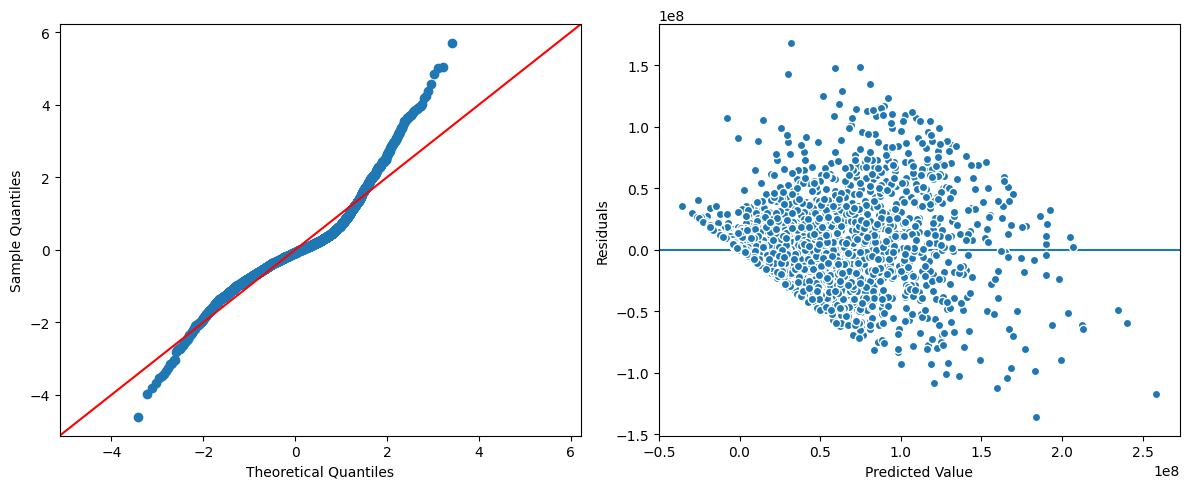

In [66]:
## MAKE NEW MODEL WITH IQR OUTLIERS REMOVED

X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr)
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
display(result.summary())
evaluate_ols(result,X_train_df,y_train)

## P Values

In [67]:
## get pvalues from model result
pvals = result.pvalues 
pvals

adult                              8.501741e-01
budget                            2.635977e-129
popularity                         2.852243e-14
runtime                            3.945559e-03
vote_average                       2.623334e-01
                                      ...      
ProdComp_Warner Bros. Pictures     1.203380e-01
ProdComp_Wild Bunch                1.209066e-01
ProdComp_ZDF                       4.242756e-01
ProdComp_Česká televize                     NaN
const                              3.508368e-04
Length: 87, dtype: float64

In [68]:
## Check for p-values that are >.05
pvals[ pvals>.05]

adult                                              0.850174
vote_average                                       0.262333
month                                              0.139960
day                                                0.339627
Genre_Horror                                       0.586451
Genre_Music                                        0.056442
Genre_Thriller                                     0.657719
Genre_Crime                                        0.182031
Genre_Romance                                      0.095285
Genre_Adventure                                    0.107249
Genre_Animation                                    0.359525
Genre_Family                                       0.359994
Genre_History                                      0.166958
Genre_War                                          0.492184
Genre_Mystery                                      0.107296
Genre_Documentary                                  0.816860
ProdComp_01 Distribution                

In [69]:

## Get list of ALL genre columns to see how many are sig
genre_cols = [c for c in df_clean.columns if c.startswith("Genre")]
genre_cols

['Genre_Drama',
 'Genre_Science Fiction',
 'Genre_Comedy',
 'Genre_Horror',
 'Genre_Music',
 'Genre_Thriller',
 'Genre_Crime',
 'Genre_Romance',
 'Genre_Adventure',
 'Genre_Action',
 'Genre_Fantasy',
 'Genre_Animation',
 'Genre_Family',
 'Genre_History',
 'Genre_War',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_Documentary',
 'Genre_TV Movie']

In [70]:
## save just genre pvalues
genre_pvals = pvals[genre_cols]
## calc what % are insig?
genre_pvals.sum()/len(genre_pvals)

0.21398664928364294

In [71]:
## Get list of ALL prod_comp columns to see how many are sig
comp_cols = [c for c in df_clean.columns if c.startswith("ProdComp")]
comp_cols

['ProdComp_01 Distribution',
 'ProdComp_20th Century Fox',
 'ProdComp_ARD',
 'ProdComp_ARTE',
 'ProdComp_ARTE France Cinéma',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_CNC',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Eurimages',
 'ProdComp_Film i Väst',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_France Télévisions',
 'ProdComp_Gaumont',
 'ProdComp_Globo Filmes',
 'ProdComp_Kadokawa',
 'ProdComp_Lionsgate',
 'ProdComp_Lotte Entertainment',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_MiC',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_Nordisk Film',
 'ProdComp_Paramount',
 'ProdComp_RAI',
 'ProdComp_RAI Cinema',
 'ProdComp_Relativity Media',
 'ProdComp_Shochiku',
 'ProdComp_Showbox',
 'ProdComp_Star Cinema – ABS-CBN Film Productions',
 'ProdCo

In [72]:
## save just genre pvalues
comp_pvals = pvals[comp_cols]
comp_pvals.sum()/len(comp_pvals)

0.36794485834771473

In [73]:
## what pvals are remaining?
other_pvals = pvals.drop([*comp_cols, *genre_cols])
other_pvals[other_pvals>.05]

adult           0.850174
vote_average    0.262333
month           0.139960
day             0.339627
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     78.09
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:44:26   Log-Likelihood:                -59432.
No. Observations:                3192   AIC:                         1.190e+05
Df Residuals:                    3113   BIC:                         1.195e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
budget                                              0.7828      0.031     25.366      0.000       0.722       0.843
popularity                                       4.633e+05   5.87e+04      7.889      0.000    3.48e+05    5.78e+05
runtime                                          1.133e+05   3.63e+04      3.119      0.002    4.21e+04    1.85e+05
vote_count                                       1.225e+04    438.821     27.921      0.000    1.14e+04    1.31e+04
year                                            -3.802e+05   1.04e+05     -3.653      0.000   -5.84e+05   -1.76e+05
certifcation_G                                   1.099e+08   2.63e+07      4.178      0.000    5.83e+07    1.62e+08
certifcation_MISSING                             9.129e+07   2.64e+07      3.458      0.001    3.95e+07    1.43e+08
certifcation_NC-17                               8.983e+07   2.74e+07      3.282      0.001    3.62e+07    1.43e+08
certifcation_NR                                  9.126e+07   2.64e+07      3.458      0.001    3.95e+07    1.43e+08
certifcation_PG                                    9.9e+07   2.62e+07      3.778      0.000    4.76e+07     1.5e+08
certifcation_PG-13                               9.603e+07   2.61e+07      3.673      0.000    4.48e+07    1.47e+08
certifcation_R                                   8.284e+07   2.61e+07      3.170      0.002    3.16e+07    1.34e+08
belongs_to_collection                            1.792e+07   1.59e+06     11.233      0.000    1.48e+07     2.1e+07
Genre_Drama                                     -5.259e+06   1.37e+06     -3.850      0.000   -7.94e+06   -2.58e+06
Genre_Science Fiction                           -1.795e+07   2.17e+06     -8.256      0.000   -2.22e+07   -1.37e+07
Genre_Comedy                                     4.645e+06   1.39e+06      3.348      0.001    1.92e+06    7.37e+06
Genre_Horror                                     9.394e+05   2.01e+06      0.466      0.641   -3.01e+06    4.89e+06
Genre_Music                                      6.183e+06   3.21e+06      1.928      0.054   -1.06e+05    1.25e+07
Genre_Thriller                                   6.891e+05   1.49e+06      0.461      0.645   -2.24e+06    3.62e+06
Genre_Crime                                     -2.114e+06   1.67e+06     -1.266      0.206   -5.39e+06    1.16e+06
Genre_Romance                                    2.572e+06   1.49e+06      1.730      0.084   -3.44e+05    5.49e+06
Genre_Adventure                                 -3.122e+06   1.94e+06     -1.611      0.107   -6.92e+06    6.79e+05
Genre_Action                                    -3.146e+06   1.52e+06     -2.075      0.038   -6.12e+06   -1.74e+05
Genre_Fantasy                                   -8.186e+06   2.11e+

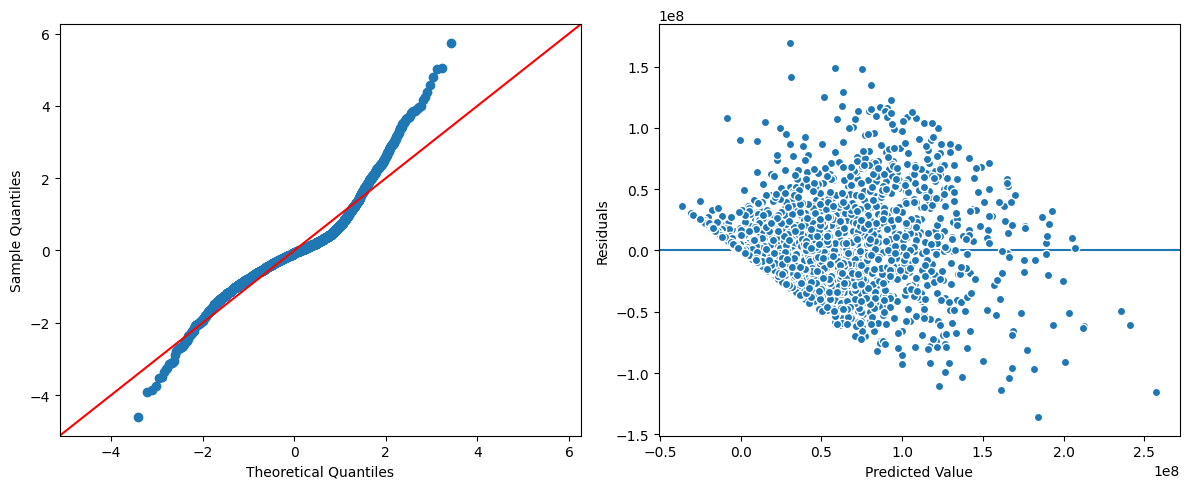

In [74]:
## Make x,y vars, but drop features with bad pvalues
df_clean_iqr = df_clean_iqr.drop(columns=['adult','vote_average', 'month', 'day'])
X_train_df, y_train, X_test_df, y_test = \
                                get_train_test_split(df_clean_iqr,)
## MAKE AND EVALUATE OLS
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

## VIF Score

In [76]:
# separate just x-data and subtract mean
features = X_train_df -  X_train_df.mean()

features

,budget,popularity,runtime,vote_count,year,certifcation_G,certifcation_MISSING,certifcation_NC-17,certifcation_NR,certifcation_PG,...,ProdComp_Toei Company,ProdComp_Toho,ProdComp_Téléfilm Canada,ProdComp_Universal Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_ZDF,ProdComp_Česká televize,const
10297,-1.601603e+07,22.766329,-6.851817,-503.85307,6.725361,-0.012845,0.750627,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
27596,-1.441603e+07,29.813329,17.148183,3637.14693,9.725361,-0.012845,0.750627,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,0.946742,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
14306,8.583967e+06,38.021329,-21.851817,596.14693,-1.274639,-0.012845,-0.249373,-0.003759,-0.031015,0.916353,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
14923,-1.241603e+07,-10.363671,28.148183,-1055.85307,-1.274639,-0.012845,0.750627,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
45412,-1.981424e+07,-7.924671,-10.851817,-990.85307,-5.274639,-0.012845,0.750627,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,0.994674,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,-1.941603e+07,-14.979671,13.148183,-1133.85307,-7.274639,-0.012845,-0.249373,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
3815,4.858397e+07,2.794329,27.148183,-288.85307,-4.274639,-0.012845,-0.249373,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
46793,-1.091603e+07,-8.642671,26.148183,-1057.85307,3.725361,-0.012845,0.750627,-0.003759,-0.031015,-0.083647,...,-0.00094,0.994361,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0
55192,4.583967e+06,0.376329,-11.851817,2403.14693,-6.274639,-0.012845,-0.249373,-0.003759,-0.031015,-0.083647,...,-0.00094,-0.005639,-0.003759,-0.053258,-0.015351,-0.042293,-0.006579,-0.005326,0.0,0.0


In [77]:
## create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)
VIF

/home/vanica/anaconda3/envs/dojo-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/vanica/anaconda3/envs/dojo-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


budget                            2.050296
popularity                        2.045207
runtime                           1.378884
vote_count                        1.780329
year                              1.230871
                                    ...   
ProdComp_Warner Bros. Pictures    1.138751
ProdComp_Wild Bunch               1.059818
ProdComp_ZDF                      1.378401
ProdComp_Česká televize                NaN
const                                  NaN
Length: 83, dtype: float64

In [78]:
## Sort VIF for inspect
VIF.sort_values()

ProdComp_Star Cinema – ABS-CBN Film Productions    1.014920
ProdComp_Toei Company                              1.015317
Genre_Documentary                                  1.016695
ProdComp_Lotte Entertainment                       1.021190
ProdComp_BBC Films                                 1.025334
                                                     ...   
certifcation_NR                                         inf
Genre_TV Movie                                          NaN
ProdComp_MISSING                                        NaN
ProdComp_Česká televize                                 NaN
const                                                   NaN
Length: 83, dtype: float64

In [79]:
## Set float format to view vals not in scientfic notation
pd.set_option('display.float_format',lambda x: f'{x:.2f}')

In [80]:
## remove infinite values from VIF and sort
VIF = VIF[VIF!=np.inf].sort_values()
VIF

ProdComp_Star Cinema – ABS-CBN Film Productions   1.01
ProdComp_Toei Company                             1.02
Genre_Documentary                                 1.02
ProdComp_Lotte Entertainment                      1.02
ProdComp_BBC Films                                1.03
                                                  ... 
ProdComp_ARTE France Cinéma                       6.22
Genre_TV Movie                                     NaN
ProdComp_MISSING                                   NaN
ProdComp_Česká televize                            NaN
const                                              NaN
Length: 76, dtype: float64

In [81]:
## filter for VIF that are > 5
VIF[VIF>5]

ProdComp_ARTE                 5.91
ProdComp_ARTE France Cinéma   6.22
dtype: float64

In [82]:
## save name of features with high vif
high_vif = VIF[VIF>5].index
high_vif

Index(['ProdComp_ARTE', 'ProdComp_ARTE France Cinéma'], dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     80.16
Date:                Sat, 22 Oct 2022   Prob (F-statistic):               0.00
Time:                        09:48:22   Log-Likelihood:                -59433.
No. Observations:                3192   AIC:                         1.190e+05
Df Residuals:                    3115   BIC:                         1.195e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
budget                                              0.7827      0.031     25.367      0.000       0.722       0.843
popularity                                       4.631e+05   5.87e+04      7.888      0.000    3.48e+05    5.78e+05
runtime                                          1.128e+05   3.63e+04      3.105      0.002    4.16e+04    1.84e+05
vote_count                                       1.225e+04    438.564     27.937      0.000    1.14e+04    1.31e+04
year                                            -3.789e+05   1.04e+05     -3.642      0.000   -5.83e+05   -1.75e+05
certifcation_G                                   1.096e+08   2.63e+07      4.168      0.000     5.8e+07    1.61e+08
certifcation_MISSING                             9.103e+07   2.64e+07      3.450      0.001    3.93e+07    1.43e+08
certifcation_NC-17                               8.941e+07   2.74e+07      3.268      0.001    3.58e+07    1.43e+08
certifcation_NR                                  9.096e+07   2.64e+07      3.448      0.001    3.92e+07    1.43e+08
certifcation_PG                                  9.868e+07   2.62e+07      3.767      0.000    4.73e+07     1.5e+08
certifcation_PG-13                               9.574e+07   2.61e+07      3.663      0.000    4.45e+07    1.47e+08
certifcation_R                                   8.258e+07   2.61e+07      3.161      0.002    3.14e+07    1.34e+08
belongs_to_collection                            1.792e+07   1.59e+06     11.242      0.000    1.48e+07     2.1e+07
Genre_Drama                                     -5.243e+06   1.37e+06     -3.839      0.000   -7.92e+06   -2.57e+06
Genre_Science Fiction                           -1.794e+07   2.17e+06     -8.255      0.000   -2.22e+07   -1.37e+07
Genre_Comedy                                     4.648e+06   1.39e+06      3.352      0.001    1.93e+06    7.37e+06
Genre_Horror                                     9.318e+05   2.01e+06      0.463      0.644   -3.02e+06    4.88e+06
Genre_Music                                      6.289e+06    3.2e+06      1.963      0.050    6974.328    1.26e+07
Genre_Thriller                                   6.769e+05   1.49e+06      0.454      0.650   -2.25e+06     3.6e+06
Genre_Crime                                     -2.124e+06   1.67e+06     -1.272      0.203    -5.4e+06    1.15e+06
Genre_Romance                                    2.598e+06   1.49e+06      1.748      0.081   -3.16e+05    5.51e+06
Genre_Adventure                                 -3.087e+06   1.94e+06     -1.593      0.111   -6.89e+06    7.12e+05
Genre_Action                                    -3.164e+06   1.52e+06     -2.088      0.037   -6.13e+06   -1.93e+05
Genre_Fantasy                                   -8.203e+06   2.11e+

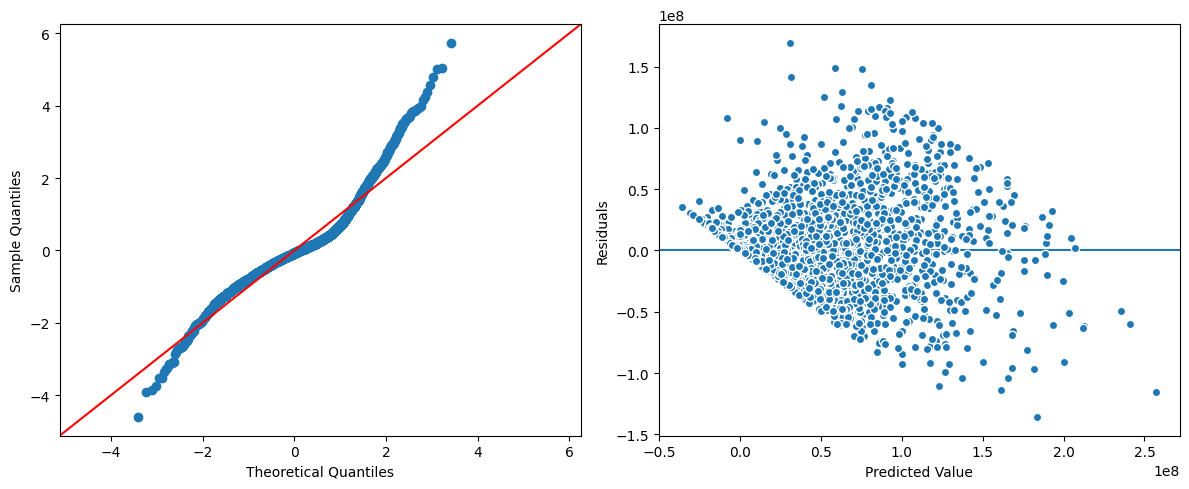

In [83]:

## make new df_final copy of prev df
df_final = df_clean_iqr.drop(columns =high_vif).copy()
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_final)
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)